<center>
<h1> Basic Natural Language Processing
</center>

###### Basic Sentiment analysis on Movie dataset. This dataset is available at Kaggle and provided by University of Michigan.
###### https://www.kaggle.com/c/si650winter11/data

In [6]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

sentitraindf = pd.read_csv('sentiment_train.csv',delimiter='\t')
sentitraindf.head(5)

,sentiment,text
0,1,The Da Vinci Code book is just awesome.
1,1,this was the first clive cussler i've ever rea...
2,1,i liked the Da Vinci Code a lot.
3,1,i liked the Da Vinci Code a lot.
4,1,I liked the Da Vinci Code but it ultimatly did...


## Text Pre-processing

###### BoW (Bag of Words) Model 

###### Method-1 : Count Vector

###### Note 1 : Create dictionary corpus across all documents. The documents will be represented by number of times each word appears in the document.
###### Note 2 : Observe the F-string literal used for printing text. This comes in handy for formatting text and display.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()

identifiedfeatures_vector = count_vectorizer.fit(sentitraindf.text)

identifiedfeatures = identifiedfeatures_vector.get_feature_names()
numberoffeatures = len(identifiedfeatures)
print(f"Total number of features: {numberoffeatures}")

Total number of features: 2132


## Transform documents into vectors using transform

In [14]:
train_identifiedfeatures = count_vectorizer.transform(sentitraindf.text)
train_identifiedfeatures.shape

(6918, 2132)

## Sparse Matrix checking

#### Sparse Matrix occurs if there are high proprotion of zeros in comparison to non-zero values in the resultant matrix.

In [15]:
nonzerovals = train_identifiedfeatures.getnnz()

In [16]:
density = nonzerovals*100/(train_identifiedfeatures.shape[0]*train_identifiedfeatures.shape[1])
print(f"Density of the matrix: {density}")

Density of the matrix: 0.4434010415225908


#### The above mentioned density matrix has less than 1% non-zero values and is a very sparse matrix.

## Counting Frequency of the features column-wise

In [22]:
features_counts = np.sum(train_identifiedfeatures.toarray(),axis=0)

featurescountdf = pd.DataFrame(dict(features=identifiedfeatures, counts = features_counts))
featurescountdf.sort_values('counts',ascending= False)[0:25]

,features,counts
1864,the,3306
93,and,2154
864,harry,2093
1466,potter,2093
355,code,2002
2009,vinci,2001
442,da,2001
1272,mountain,2000
259,brokeback,2000
1171,love,1624


##  Removing Stop Words (i.e most common words used in a language)

In [37]:
from sklearn.feature_extraction import text
stop_words_for_my_usecase = text.ENGLISH_STOP_WORDS.union(['movie','movies','harry','potter','da'
                                                  ,'vinci','code','brokeback','mountain'])

In [50]:
count_vectorizer = CountVectorizer(stop_words=stop_words_for_my_usecase,max_features=1000)

identifiedfeatures_vector = count_vectorizer.fit(sentitraindf.text)
train_identifiedfeatures = count_vectorizer.transform(sentitraindf.text)
identifiedfeatures = identifiedfeatures_vector.get_feature_names()
features_counts = np.sum(train_identifiedfeatures.toarray(),axis=0)

featurescountdf = pd.DataFrame(dict(features=identifiedfeatures, counts = features_counts))
featurescountdf.sort_values('counts',ascending= False)[0:10]

,features,counts
407,love,1624
39,awesome,1127
435,mission,1094
340,impossible,1093
389,like,974
744,sucks,602
742,sucked,600
296,hate,578
651,really,374
740,stupid,365


## Converting words into root words

## 1. Stemming

In [42]:
stop_words_for_my_usecase = text.ENGLISH_STOP_WORDS.union(['movie','movies','harry','potter','da'
                                                  ,'vinci','code','brokeback','mountain'])

from nltk.stem.snowball import PorterStemmer

stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc) :
    stemmed_words = [stemmer.stem(w) for w in analyzer(doc)]
    
    non_stop_words = [word for word in stemmed_words if not word in stop_words_for_my_usecase]
    return non_stop_words


In [51]:

count_vectorizer = CountVectorizer(analyzer=stemmed_words,max_features=1000)

identifiedfeatures_vector = count_vectorizer.fit(sentitraindf.text)
train_identifiedfeatures = count_vectorizer.transform(sentitraindf.text)
identifiedfeatures = identifiedfeatures_vector.get_feature_names()
features_counts = np.sum(train_identifiedfeatures.toarray(),axis=0)

featurescountdf = pd.DataFrame(dict(features=identifiedfeatures, counts = features_counts))
featurescountdf.sort_values('counts',ascending= False)[0:10]

,features,counts
302,harri,2093
413,love,1883
791,suck,1484
922,wa,1176
399,like,1155
446,movi,1149
45,awesom,1130
440,mission,1094
350,imposs,1093
304,hate,701


## Convert Document Vector matrix into Dataframe

In [52]:
train_nlp_df = pd.DataFrame(train_identifiedfeatures.todense())
train_nlp_df.columns = identifiedfeatures
train_nlp_df['sentiment']= sentitraindf.sentiment

## Split Dataset

In [53]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(train_identifiedfeatures,sentitraindf.sentiment,
                                                    test_size=0.3,random_state=42)

## Build Naive-Bayes Model and predict on Test Dataset

In [54]:
from sklearn.naive_bayes import BernoulliNB

nb_classifier = BernoulliNB()
nb_classifier.fit(train_X.toarray(),train_y)

test_senti_predicted = nb_classifier.predict(test_X.toarray())

## Metrics Classification Report - Model Accuracy

In [55]:
from sklearn import metrics

print(metrics.classification_report(test_y, test_senti_predicted))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       873
           1       0.98      0.99      0.98      1203

    accuracy                           0.98      2076
   macro avg       0.98      0.98      0.98      2076
weighted avg       0.98      0.98      0.98      2076



## Confusion Matrix

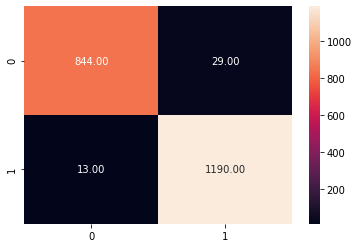

In [56]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

cm = metrics.confusion_matrix(test_y, test_senti_predicted)
sns.heatmap(cm,annot=True, fmt='0.2f');